### Context
Here we try to create an algorithm to maximise profit across the S&P500. This version of the model will only take use signals derived from historical prices as found in the data, `sp500.csv`. Here we add all imports and download the data:

In [558]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [559]:
# Define ticker and timeframe
ticker = "^GSPC"
start_date = "1950-01-03"
end_date = datetime.today().strftime('%Y-%m-%d')

# Download and save to CSV
sp500 = yf.download(ticker, start=start_date, end=end_date)
sp500.to_csv("sp500_data.csv")
print("Saved to sp500_data.csv")
print(sp500.head())

/var/folders/t5/x93h4kds34110n67wlm59khw0000gn/T/ipykernel_64431/2367403757.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Saved to sp500_data.csv
Price       Close   High    Low   Open   Volume
Ticker      ^GSPC  ^GSPC  ^GSPC  ^GSPC    ^GSPC
Date                                           
1950-01-03  16.66  16.66  16.66  16.66  1260000
1950-01-04  16.85  16.85  16.85  16.85  1890000
1950-01-05  16.93  16.93  16.93  16.93  2550000
1950-01-06  16.98  16.98  16.98  16.98  2010000
1950-01-09  17.08  17.08  17.08  17.08  2520000


Here we load the dataframe and parse as necessary:

In [560]:
# Load the CSV
columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df = pd.read_csv("sp500_data.csv", skiprows=3, names=columns)

# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Set 'Date' as index
df.set_index('Date', inplace=True)

# Display the first few rows
print(df.head())

            Close   High    Low   Open   Volume
Date                                           
1950-01-03  16.66  16.66  16.66  16.66  1260000
1950-01-04  16.85  16.85  16.85  16.85  1890000
1950-01-05  16.93  16.93  16.93  16.93  2550000
1950-01-06  16.98  16.98  16.98  16.98  2010000
1950-01-09  17.08  17.08  17.08  17.08  2520000


At this point we want to think about the signals that we want to use for our algorithm. Let us just define some of the more basic columns, such as `Daily Return` and `Cumulative Returns`.

In [561]:
def calculate_metrics(df):
    """
    Calculate financial metrics from the DataFrame.
    """
    df['Daily Return'] = df['Close'].pct_change()
    df['Log Return'] = np.log(df['Close'] / df['Close'].shift(1))
    df['Cumulative Returns'] = (1 + df['Daily Return']).cumprod() - 1
    df['Volatility'] = df['Log Return'].rolling(window=30).std()
    
    df.dropna(inplace=True)  # Drop rows with NaN values
    
    return df


Let us take a look at `Cumulative Returns` of the S&P 500 across the years (let's just take from 20 years ago)

In [562]:
end = datetime.today().strftime('%Y-%m-%d')
start = (datetime.today() - timedelta(days=365 * 20)).strftime('%Y-%m-%d')  # 20 years ago

In [563]:
import matplotlib.pyplot as plt

def plot_cumulative_returns(df, start=None, end=None):
    """
    Plots cumulative returns of S&P 500 between optional start and end dates.

    Parameters:
    - df: DataFrame with a DateTime index and a column named 'Cumulative Returns'
    - start: str or datetime (optional), start date for slicing
    - end: str or datetime (optional), end date for slicing
    """
    # Ensure index is datetime
    df = df.copy()
    df.index = pd.to_datetime(df.index)

    # Apply date filtering
    if start or end:
        df = df.loc[start:end]

    # Calculate metrics from scratch
    df = calculate_metrics(df)

    plt.figure(figsize=(14, 7))
    plt.plot(df['Cumulative Returns'], label='Cumulative Returns')
    plt.title('Cumulative Returns of S&P 500')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.grid(True)
    plt.show()


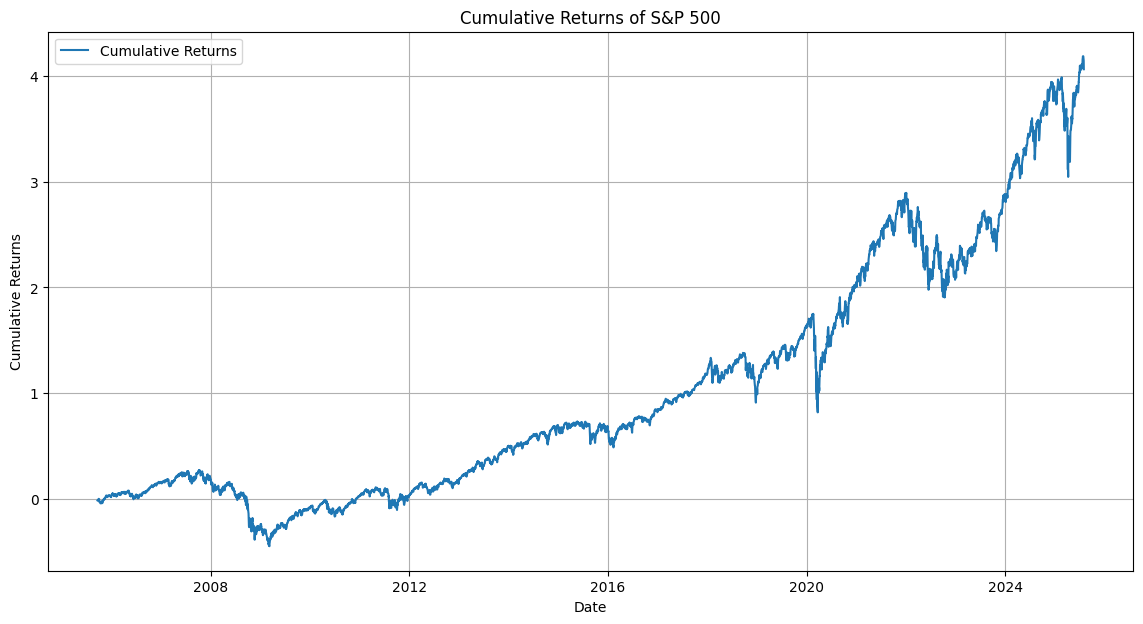

In [564]:
plot_cumulative_returns(df, start=start, end=end)


Now, let's take a look at the run-up and drawdown graphs:

In [565]:
import matplotlib.pyplot as plt
import pandas as pd

def calculate_drawdown_and_runup(df, threshold=-0.20):
    """
    Calculate drawdown and run-up from the DataFrame with 'Cumulative Returns'.
    
    Parameters:
    - df: DataFrame with DateTime index and 'Cumulative Returns' column
    - threshold: float, reset threshold for run-up (default: -0.20 for 20% drawdown)
    
    Returns:
    - df: DataFrame with 'Drawdown' and 'Run-up' columns added
    """
    df = df.copy()
    df.index = pd.to_datetime(df.index)

    # Calculate metrics from scratch
    df = calculate_metrics(df)

    # Drawdown calculation
    df['Drawdown'] = df['Cumulative Returns'] - df['Cumulative Returns'].cummax()

    # Run-up logic
    run_up = []
    current_base = df['Cumulative Returns'].iloc[0]
    
    for i in range(len(df)):
        if df['Drawdown'].iloc[i] <= threshold:
            current_base = df['Cumulative Returns'].iloc[i]
        
        run_up_val = df['Cumulative Returns'].iloc[i] - current_base
        run_up.append(run_up_val)
    
    df['Run-up'] = run_up

    return df

def plot_drawdown_and_runup(df, threshold=-0.20, start=None, end=None):
    """
    Plots drawdown and run-up for a given DataFrame with a 'Cumulative Returns' column.
    
    Parameters:
    - df: DataFrame with DateTime index and 'Cumulative Returns' column
    - threshold: float, reset threshold for run-up (default: -0.20 for 20% drawdown)
    - start: str or datetime (optional), start date to filter
    - end: str or datetime (optional), end date to filter
    """
    df = df.copy()
    df.index = pd.to_datetime(df.index)

    if start or end:
        df = df.loc[start:end]

    # Calculate metrics from scratch
    df = calculate_metrics(df)

    # Drawdown & Run-up calculation
    df = calculate_drawdown_and_runup(df, threshold)

    # Plot
    fig, axs = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

    axs[0].plot(df.index, df['Drawdown'], color='red', label='Drawdown')
    axs[0].set_title('Drawdown of S&P 500')
    axs[0].set_ylabel('Drawdown')
    axs[0].legend()
    axs[0].grid(True)

    axs[1].plot(df.index, df['Run-up'], color='green', label='Run-up')
    axs[1].set_title(f'Run-up Periods (Resets When Drawdown ≤ {threshold*100:.0f}%)')
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('Run-up')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()


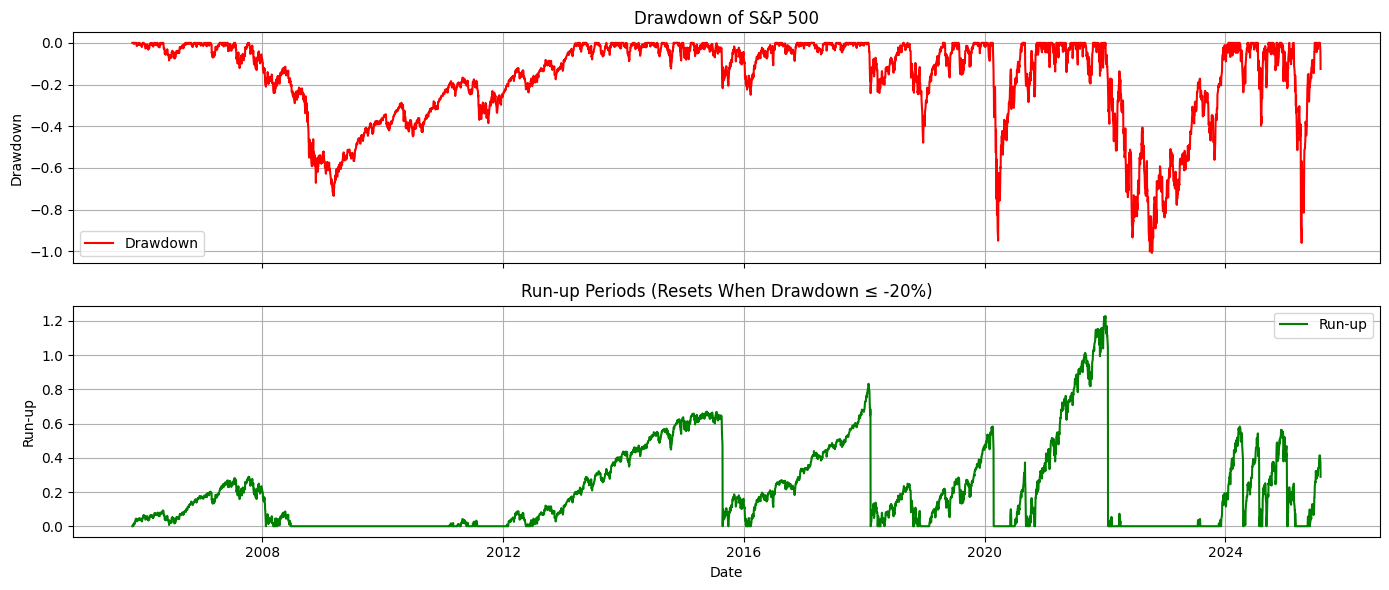

In [566]:
plot_drawdown_and_runup(df, threshold=-0.20, start=start, end=end)

This data isn't particularly significant by itself, and it'd be helpful to look at the data in relation to market regimes and cumulative returns. 

To categorise the historical data into the different regimes (bull, bear), we can either use the official definitions (drawdown <= -20% for bear start, run-up >= 20% for bull start) or try to classify them using statistical methods. Here, I'll opt to classify the data via hidden markov models (HMM). 

In [567]:
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

def detect_market_regimes(df, features=['Log Return', 'Volatility'], n_components=3, random_state=42):
    """
    Fits a Gaussian HMM to specified features and assigns market regimes.

    Parameters:
    - df: pandas DataFrame containing the required features and 'Cumulative Returns'
    - features: list of column names to use as features for HMM (default: ['Log Return', 'Volatility'])
    - n_components: number of hidden states/regimes (default: 3)
    - random_state: random seed for reproducibility

    Returns:
    - df_result: DataFrame with a new 'Regime' column assigned
    - model: trained HMM model
    """
    df = calculate_metrics(df)  # Ensure metrics are calculated
    df_result = df.dropna().copy()

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_result[features].values)

    # Fit Gaussian HMM
    model = GaussianHMM(n_components=n_components, covariance_type='full',
                        n_iter=1000, random_state=random_state)
    model.fit(X_scaled)

    # Predict regimes
    df_result['Regime'] = model.predict(X_scaled)

    # Print regime summary
    for i in range(n_components):
        mask = df_result['Regime'] == i
        mean_ret = df_result.loc[mask, 'Log Return'].mean()
        vol = df_result.loc[mask, 'Log Return'].std()
        print(f"Regime {i}: Mean Return = {mean_ret:.5f}, Volatility = {vol:.5f}")

    return df_result, model


In [568]:
detect_market_regimes(df, features=['Log Return', 'Volatility'], n_components=3)

Regime 0: Mean Return = 0.00032, Volatility = 0.00845
Regime 1: Mean Return = 0.00037, Volatility = 0.00539
Regime 2: Mean Return = 0.00019, Volatility = 0.01717


(                  Close         High          Low         Open      Volume  \
 Date                                                                         
 1950-02-15    17.059999    17.059999    17.059999    17.059999     1730000   
 1950-02-16    16.990000    16.990000    16.990000    16.990000     1920000   
 1950-02-17    17.150000    17.150000    17.150000    17.150000     1940000   
 1950-02-20    17.200001    17.200001    17.200001    17.200001     1420000   
 1950-02-21    17.170000    17.170000    17.170000    17.170000     1260000   
 ...                 ...          ...          ...          ...         ...   
 2025-07-28  6389.770020  6401.069824  6375.790039  6397.689941  4565620000   
 2025-07-29  6370.859863  6409.259766  6363.919922  6405.620117  5076120000   
 2025-07-30  6362.899902  6396.540039  6336.379883  6381.229980  5375070000   
 2025-07-31  6339.390137  6427.020020  6327.640137  6427.020020  6077080000   
 2025-08-01  6238.009766  6287.279785  6212.689941  

Given the above hidden states, we can deduce that `Regime 2` is **a bear market**, since it is the only regime with a negative mean return. It also has a high volatility, indicating market uncertainty characteristic of a bear market.

Given that `Regime 1` has a slightly higher mean return and a significantly lower volatility compared to `Regime 0`, it is more likely to be **a bull market** as it is characteristic with the high confidence in the market. It is expected that `Regime 0`, being **a neutral market**, would still have a positive mean return since stock prices always tend to increase, and the higher volatility than the bull regime still suggests investor indecision and macro noise.

In [569]:
def plot_regime_analysis(df, start=None, end=None, features=['Log Return', 'Volatility'], n_components=3, regime_colors=None):
    """
    Detects HMM market regimes and plots:
    - Cumulative returns with regime shading
    - Cumulative returns + drawdown + run-up (with same shading)
    """
    # Filter date range
    df = df.copy()
    df.index = pd.to_datetime(df.index)
    if start or end:
        df = df.loc[start:end]

    # Detect regimes using HMM
    df_plot, _ = detect_market_regimes(df, features=features, n_components=n_components)
    df_plot = calculate_drawdown_and_runup(df_plot, threshold=-0.20)

    # Assign colors based on regime statistics
    regime_stats = []
    for i in range(n_components):
        mask = df_plot['Regime'] == i
        mean_ret = df_plot.loc[mask, 'Log Return'].mean()
        vol = df_plot.loc[mask, 'Log Return'].std()
        regime_stats.append({'regime': i, 'mean_ret': mean_ret, 'vol': vol})

    # Sort regimes: lowest return/highest vol is red, highest return/lowest vol is green, others grey
    sorted_stats = sorted(regime_stats, key=lambda x: (x['mean_ret'], -x['vol']))
    colors = {}
    if n_components == 2:
        # Red: lower return/higher vol, Green: higher return/lower vol
        colors[sorted_stats[0]['regime']] = 'red'
        colors[sorted_stats[1]['regime']] = 'green'
    elif n_components == 3:
        # Red: lowest return/highest vol, Green: highest return/lower vol, Grey: middle
        colors[sorted_stats[0]['regime']] = 'red'
        colors[sorted_stats[2]['regime']] = 'green'
        colors[sorted_stats[1]['regime']] = 'grey'
    else:
        # Default to grey for all
        for stat in sorted_stats:
            colors[stat['regime']] = 'grey'

    regime_colors = colors

    # Prepare plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True, gridspec_kw={'height_ratios': [1, 1]})

    # === Top: Cumulative Returns with regime shading ===
    ax1.plot(df_plot.index, df_plot['Cumulative Returns'], color='blue', label='Cumulative Returns')
    ax1.set_ylabel("Cumulative Returns")
    ax1.set_title("Cumulative Returns with HMM Regime Shading")
    ax1.grid(True)

    current_regime = None
    start_date = None
    for date, regime in zip(df_plot.index, df_plot['Regime']):
        if regime != current_regime:
            if current_regime is not None:
                ax1.axvspan(start_date, date, color=regime_colors.get(current_regime, 'grey'), alpha=0.2)
            current_regime = regime
            start_date = date
    ax1.axvspan(start_date, df_plot.index[-1], color=regime_colors.get(current_regime, 'grey'), alpha=0.2)

    # === Bottom: Same with Drawdown and Run-up ===
    ax2.plot(df_plot.index, df_plot['Cumulative Returns'], color='blue', label='Cumulative Returns')
    ax2.set_ylabel("Cumulative Returns")
    ax2.set_title("Cumulative Returns with Drawdown/Run-up and Regime Shading")
    ax2.grid(True)

    current_regime = None
    start_date = None
    for date, regime in zip(df_plot.index, df_plot['Regime']):
        if regime != current_regime:
            if current_regime is not None:
                ax2.axvspan(start_date, date, color=regime_colors.get(current_regime, 'grey'), alpha=0.2)
            current_regime = regime
            start_date = date
    ax2.axvspan(start_date, df_plot.index[-1], color=regime_colors.get(current_regime, 'grey'), alpha=0.2)

    # Secondary axis for drawdown/run-up
    ax2b = ax2.twinx()
    ax2b.plot(df_plot.index, df_plot.loc[df_plot.index, 'Drawdown'], color='red', label='Drawdown', alpha=0.5)
    ax2b.plot(df_plot.index, df_plot.loc[df_plot.index, 'Run-up'], color='green', label='Run-up', alpha=0.5)
    ax2b.set_ylabel("Drawdown / Run-up")
    ax2b.legend(loc='upper left')

    fig.align_ylabels()
    plt.tight_layout()
    plt.show()

Regime 0: Mean Return = 0.00058, Volatility = 0.00568
Regime 1: Mean Return = 0.00052, Volatility = 0.00915
Regime 2: Mean Return = -0.00037, Volatility = 0.02104


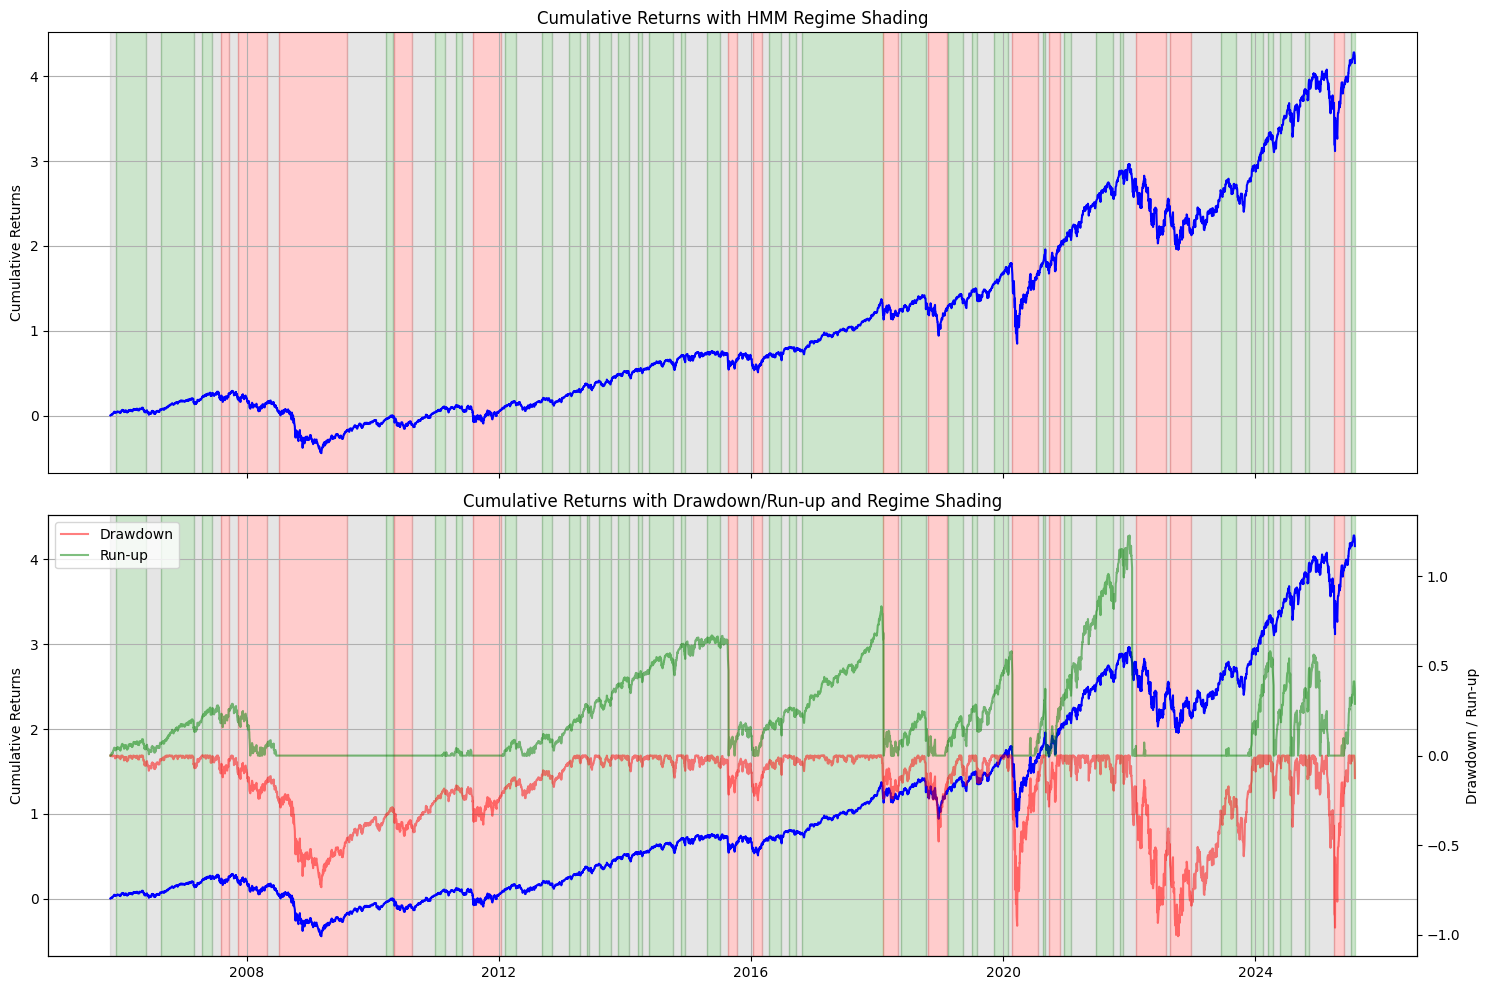

In [570]:
plot_regime_analysis(df, start=start, end=end)

Having obtained these graphs, we can see the intuitive relationship between how prices correlate to the different market regimes. What we're more interested in now is trying to predict market regimes.

Market regimes directly reflect investor confidence, hence to predict market regime changes ahead of time, we can look at proxies for investor confidence, or even looking out for signals that would impact investor confidence.

There's a lot we can do for that, but the first thing that comes to mind would be to track financial news. 

This is probably the simplest metric we can use. We try to set up **Google Cloud** to use GDELT.

Since GDELT 2.0 is only available from February 19, 2015, we set that as our start date for now (~10 years). Let's revisit the regime graph:

In [571]:
start = "2015-02-19"
end = datetime.today().strftime('%Y-%m-%d')

Regime 0: Mean Return = 0.00070, Volatility = 0.00804
Regime 1: Mean Return = 0.00058, Volatility = 0.00494
Regime 2: Mean Return = 0.00005, Volatility = 0.01676


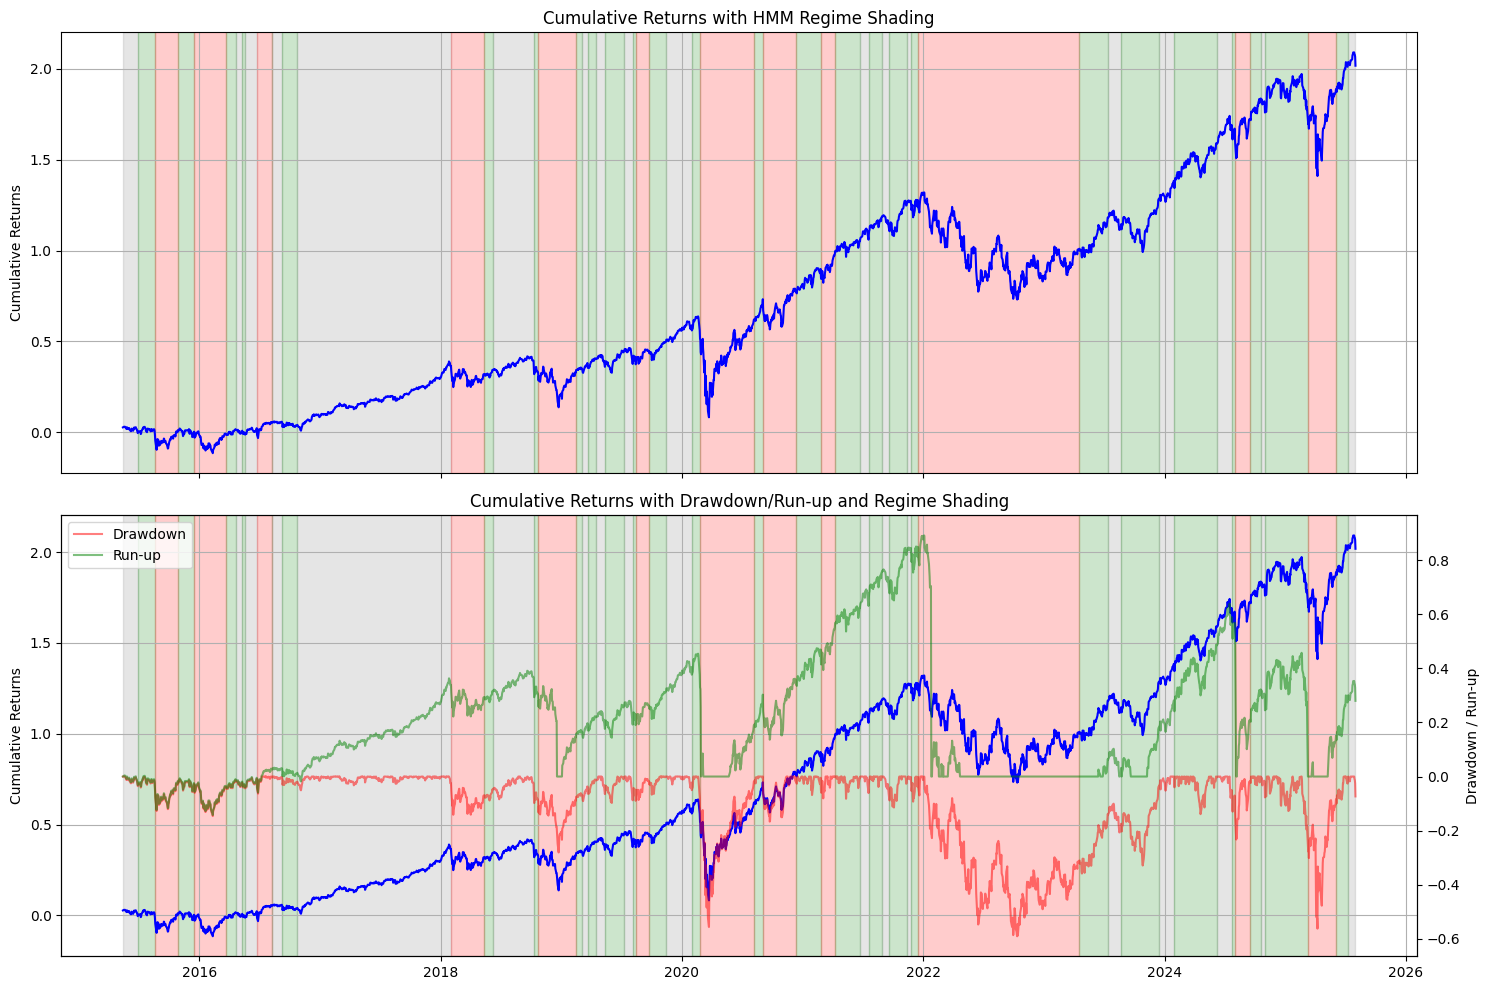

In [572]:
plot_regime_analysis(df, start=start, end=end)

With Cloud services, we always run the risk of accidentally exceeding the limit for free-tier services and incurring unintended costs. In a previous project, I manually monitored the usage of the Google Places API. In this project, I wanted to implement a script to automate billing cutoff when the budget is exceeded.

I implemented this in `budget-auto-disable`, using a **Cloud Run Function**, **Pub/Sub** and **Google Cloud Budgets**. Unfortunately, I wrote GDELC instead of GDELT for all the names inside the project, so that's what we will run with.

I initially followed https://cloud.google.com/billing/docs/how-to/disable-billing-with-notifications and the associated guides, but there were a lot of issues and the guide seemed relatively outdated, so I modified a lot of the functions with guidance from ChatGPT. We now proceed to query the necessary data from **GDELT 2.0 + GKG**:

In [573]:
from google.cloud import bigquery
from google.oauth2 import service_account

# Path to your service account JSON
key_path = "service-account.json"

# Create credentials and BigQuery client
credentials = service_account.Credentials.from_service_account_file(key_path)
client = bigquery.Client(credentials=credentials, project=credentials.project_id)

# Note: Only records from February 19, 2015 are available in the GDELT 2.0 file format

print(f"Using project: {client.project}")


Using project: gdelc-queries


In [574]:
from google.cloud import bigquery
import pandas as pd

def fetch_bulk_gkg_sentiment(start_date: str, end_date: str, themes=None, credentials=None):
    if themes is None:
        themes = [
            "ECON_STOCKMARKET", "UNEMPLOYMENT", "INFLATION", "INTEREST_RATES", "RECESSION",
            "CURRENCY", "ECON_FINANCIALCRISIS", "BANKRUPTCY", "COMMODITIES", "GDP"
        ]

    client = bigquery.Client(credentials=credentials, project=credentials.project_id if credentials else None)
    theme_filter = ' OR '.join([f'LOWER(Themes) LIKE "%{theme.lower()}%"' for theme in themes])

    query = f"""
    SELECT
        date,
        AVG(SAFE_CAST(SPLIT(V2Tone, ',')[OFFSET(0)] AS FLOAT64)) AS avg_tone,
        STDDEV(SAFE_CAST(SPLIT(V2Tone, ',')[OFFSET(0)] AS FLOAT64)) AS std_tone,
        COUNT(*) AS article_count
    FROM (
        SELECT
            PARSE_DATE('%Y%m%d', SUBSTR(GKGRECORDID, 1, 8)) AS date,
            V2Tone,
            Themes
        FROM
            `gdelt-bq.gdeltv2.gkg`
        WHERE
            PARSE_DATE('%Y%m%d', SUBSTR(GKGRECORDID, 1, 8)) BETWEEN "{start_date}" AND "{end_date}"
            AND ({theme_filter})
    )
    GROUP BY date
    ORDER BY date
    """

    print("🔍 Running 10-year bulk query...")
    df = client.query(query).to_dataframe()
    print(f"✅ Loaded {len(df)} days.")
    return df


In [575]:
gkg_start = "2015-02-19"
gkg_end = datetime.today().strftime('%Y-%m-%d')

# df_gkg = fetch_bulk_gkg_sentiment(start_date=start, end_date=end, themes=None, credentials=credentials)
# INCURS COSTS, SO COMMENTED OUT
def load_gkg_aggregate_csv(path="gkg_aggregate.csv"):
  """
  Loads the GDELT GKG aggregate sentiment CSV and returns a DataFrame
  similar to fetch_bulk_gkg_sentiment output.

  Parameters:
  - path: str, path to the CSV file

  Returns:
  - df: pandas DataFrame with datetime index and columns ['avg_tone', 'std_tone', 'article_count']
  """
  df = pd.read_csv(path, parse_dates=['date'])  # parse 'date' as datetime
  df = df[['date', 'avg_tone', 'std_tone', 'article_count']]
  df.set_index('date', inplace=True)  # ensure DatetimeIndex
  return df

df_gkg = load_gkg_aggregate_csv()

In [576]:
print(df_gkg.head())
print(len(df_gkg), "rows fetched from GDELT 2.0 GKG sentiment data.")

            avg_tone  std_tone  article_count
date                                         
2015-02-19 -0.941467  2.654329          39310
2015-02-20 -1.036728  2.712475          40211
2015-02-21 -1.295175  2.931804          18516
2015-02-22 -1.193198  2.928148          16000
2015-02-23 -0.713779  2.650501          40026
3796 rows fetched from GDELT 2.0 GKG sentiment data.


It took a significant amount of time to setup the queries, given that initially I aimed to obtain the complete, raw data. This proved to be problematic given that the table was too large to be directly streamed. I opted to break the data into chunks by years or days, but that still proved to be infeasible for the complete set of data. I settled for aggregate scores in line with ChatGPT's suggestion, which gives far greater performance (magnitude of 100-10000x faster), partially due to optimised queries (no repeat filtering) and largely due to aggregation.

In [577]:
import matplotlib.pyplot as plt

def plot_gkg_sentiment(df, start=None, end=None):
    """
    Plots GDELT sentiment data with optional date range filtering.
    Assumes 'date' is the index.
    """
    df = df.copy()
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)

    # Apply date filters
    if start:
        df = df[df.index >= pd.to_datetime(start)]
    if end:
        df = df[df.index <= pd.to_datetime(end)]

    # Plot
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['avg_tone'], label='Average Tone', color='blue')
    plt.fill_between(df.index, df['avg_tone'] - df['std_tone'], df['avg_tone'] + df['std_tone'],
                     color='lightblue', alpha=0.5, label='Standard Deviation')
    plt.title('GDELT 2.0 GKG Sentiment Analysis')
    plt.xlabel('Date')
    plt.ylabel('Average Tone')
    plt.legend()
    plt.grid(True)
    plt.show()


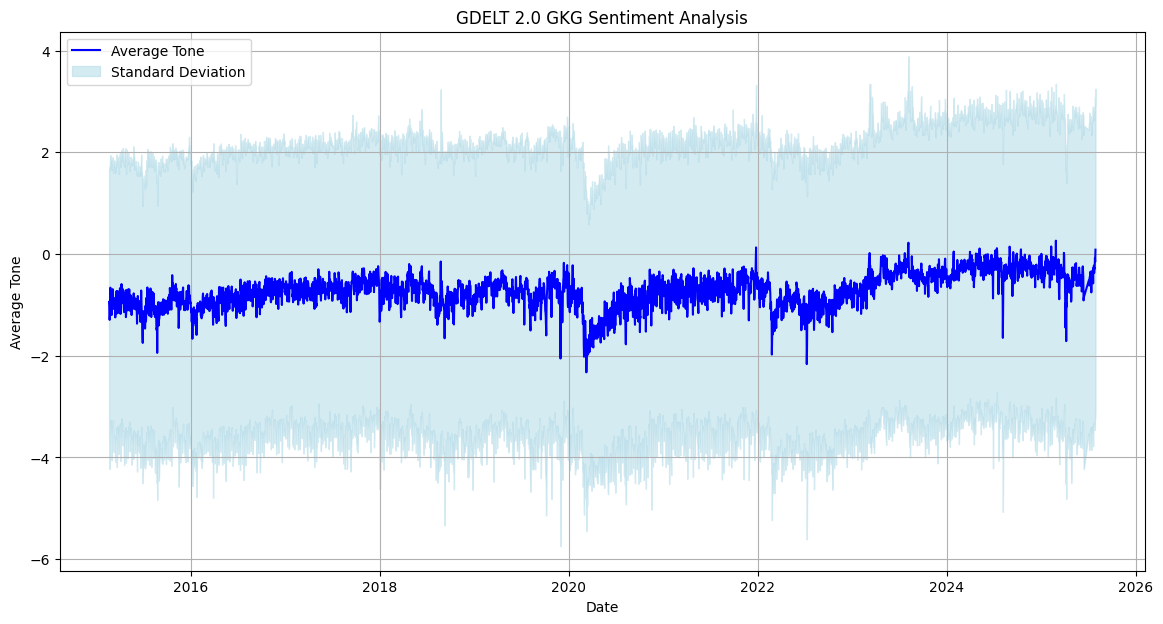

In [578]:
plot_gkg_sentiment(df_gkg, start=start, end=end)

In [579]:
# Save the processed DataFrame to a new CSV
df_gkg.to_csv("gkg_aggregate.csv", index=True)

Having obtained the aggregate sentiment data, let's try to visualise it against our regimes once more:

In [580]:
def plot_gkg_sentiment_with_cumulative_returns(df_gkg, df, start=None, end=None, n=30):
    """
    Plots n-day rolling GDELT sentiment data with cumulative returns overlay, n-day MA, and regime shading.
    Handles both column-based and index-based datetime formats.
    """

    # --- Prepare sentiment data ---
    sentiment = df_gkg.copy()

    # Ensure datetime index
    if 'date' in sentiment.columns:
        sentiment['date'] = pd.to_datetime(sentiment['date'])
        sentiment.set_index('date', inplace=True)
    if not isinstance(sentiment.index, pd.DatetimeIndex):
        sentiment.index = pd.to_datetime(sentiment.index)

    sentiment['rolling_avg_tone'] = sentiment['avg_tone'].rolling(window=n, min_periods=1).mean()
    sentiment['rolling_std_tone'] = sentiment['avg_tone'].rolling(window=n, min_periods=1).std()
    sentiment[f'{n}DSMA'] = sentiment['avg_tone'].rolling(window=n, min_periods=1).mean()

    # --- Prepare price data ---
    price_df = df.copy()
    price_df = calculate_metrics(price_df)  # make sure this does not drop rows!
    price_df[f'{n}DMA'] = price_df['Close'].rolling(window=n, min_periods=1).mean()

    # --- Detect regimes ---
    n_components = 2
    df_regime, _ = detect_market_regimes(price_df, features=['Log Return', 'Volatility'], n_components=n_components)

    # --- Final slicing ---
    start = pd.to_datetime(start) if start else max(price_df.index.min(), sentiment.index.min())
    end = pd.to_datetime(end) if end else min(price_df.index.max(), sentiment.index.max())

    sentiment = sentiment.loc[start:end]
    price_df = price_df.loc[start:end]
    df_regime = df_regime.loc[start:end]

    # --- Regime color mapping ---
    regime_stats = []
    for i in range(n_components):
        mask = df_regime['Regime'] == i
        mean_ret = df_regime.loc[mask, 'Log Return'].mean()
        vol = df_regime.loc[mask, 'Log Return'].std()
        regime_stats.append({'regime': i, 'mean_ret': mean_ret, 'vol': vol})

    sorted_stats = sorted(regime_stats, key=lambda x: (x['mean_ret'], -x['vol']))
    regime_colors = {stat['regime']: color for stat, color in zip(sorted_stats, ['red', 'green'])}

    # --- Plotting ---
    fig, ax1 = plt.subplots(figsize=(14, 7))

    ax1.plot(sentiment.index, sentiment['rolling_avg_tone'], label=f'{n}-Day Rolling Avg Tone', color='blue')
    ax1.fill_between(
        sentiment.index,
        sentiment['rolling_avg_tone'] - sentiment['rolling_std_tone'],
        sentiment['rolling_avg_tone'] + sentiment['rolling_std_tone'],
        color='lightblue', alpha=0.5, label=f'{n}-Day Rolling Std'
    )
    ax1.plot(sentiment.index, sentiment[f'{n}DSMA'], label=f'{n}-Day SMA of Rolling Avg Tone', color='darkblue', linestyle='--')
    ax1.set_ylabel('Rolling Average Tone')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.plot(price_df.index, price_df['Close'], label='Price (Close)', color='orange')
    ax2.plot(price_df.index, price_df[f'{n}DMA'], label=f'{n}-Day MA', color='yellow', linestyle='--')
    ax2.set_ylabel('Price')
    ax2.legend(loc='upper right')

    # Regime shading
    current_regime = None
    start_date = None
    for date, regime in zip(df_regime.index, df_regime['Regime']):
        if regime != current_regime:
            if current_regime is not None:
                ax2.axvspan(start_date, date, color=regime_colors.get(current_regime, 'grey'), alpha=0.2)
            current_regime = regime
            start_date = date
    if start_date is not None:
        ax2.axvspan(start_date, df_regime.index[-1], color=regime_colors.get(current_regime, 'grey'), alpha=0.2)

    plt.title(f'{n}-Day Rolling GDELT Sentiment with Cumulative Returns, {n}-Day MA, and Regime Shading')
    plt.xlabel('Date')
    plt.show()


Regime 0: Mean Return = -0.00003, Volatility = 0.01565
Regime 1: Mean Return = 0.00044, Volatility = 0.00657


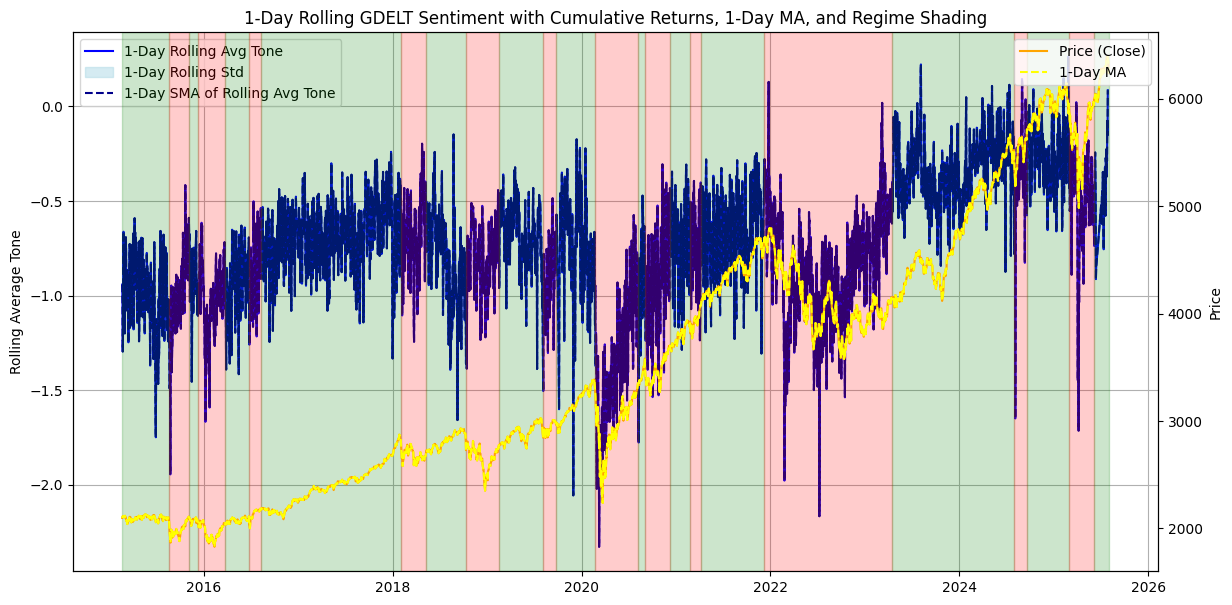

Regime 0: Mean Return = -0.00003, Volatility = 0.01565
Regime 1: Mean Return = 0.00044, Volatility = 0.00657


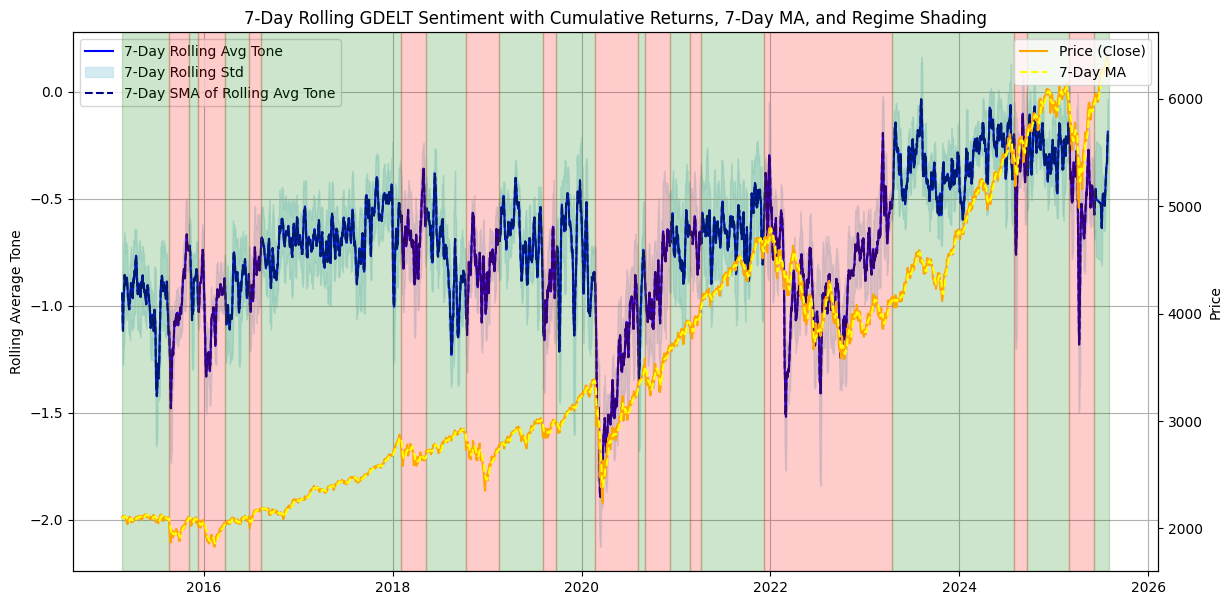

Regime 0: Mean Return = -0.00003, Volatility = 0.01565
Regime 1: Mean Return = 0.00044, Volatility = 0.00657


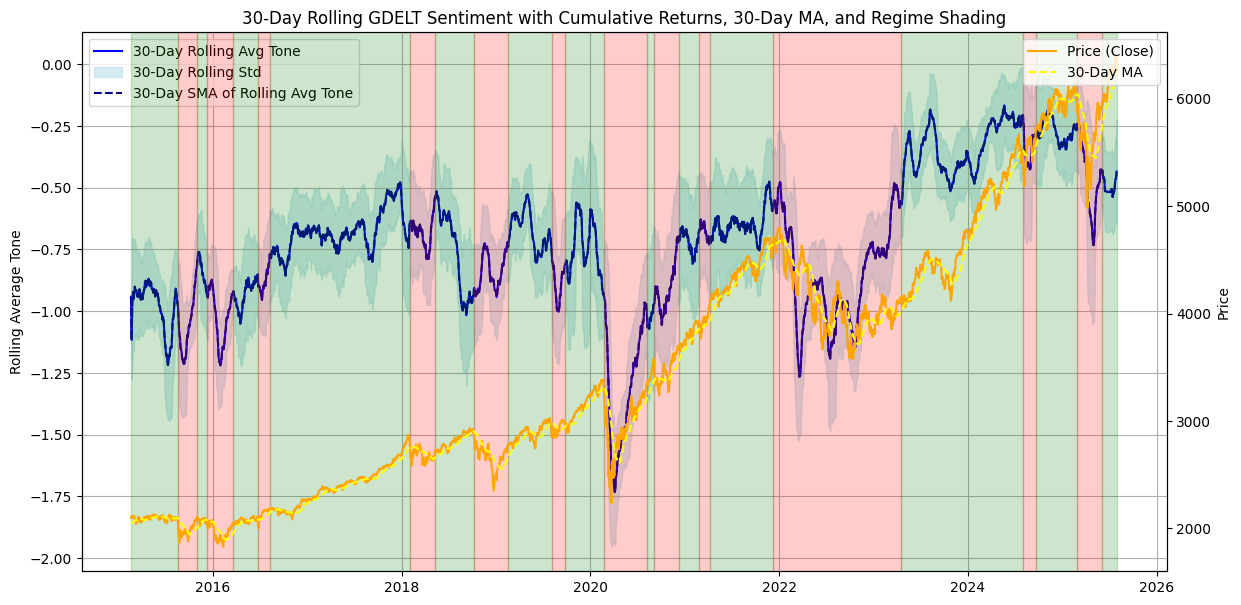

Regime 0: Mean Return = -0.00003, Volatility = 0.01565
Regime 1: Mean Return = 0.00044, Volatility = 0.00657


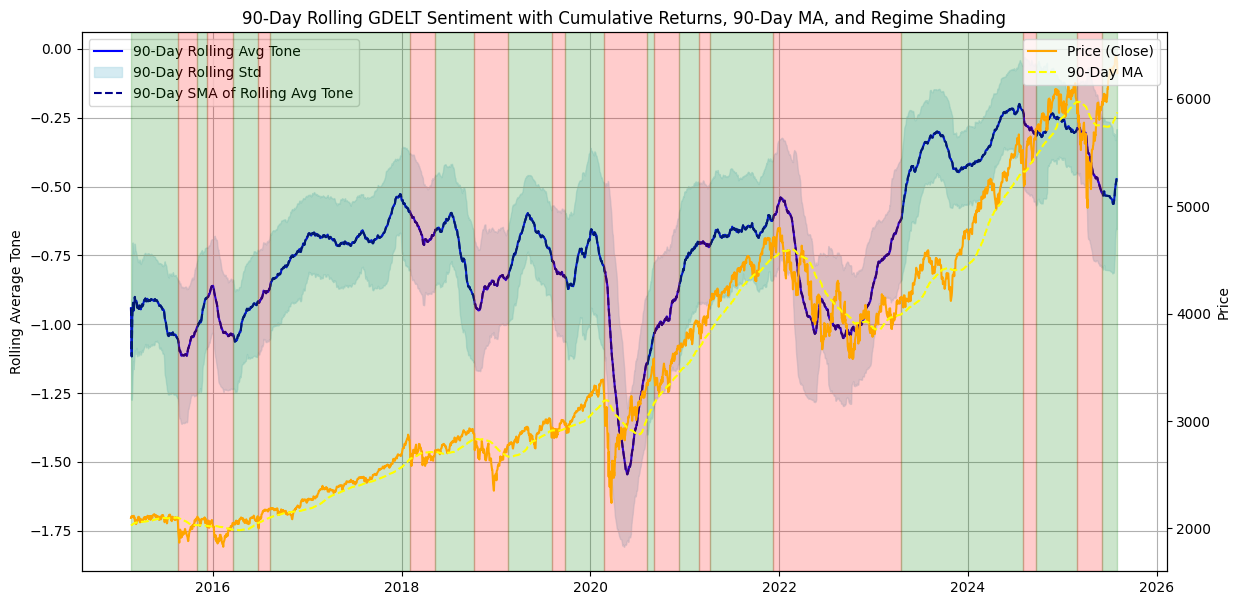

Regime 0: Mean Return = -0.00003, Volatility = 0.01565
Regime 1: Mean Return = 0.00044, Volatility = 0.00657


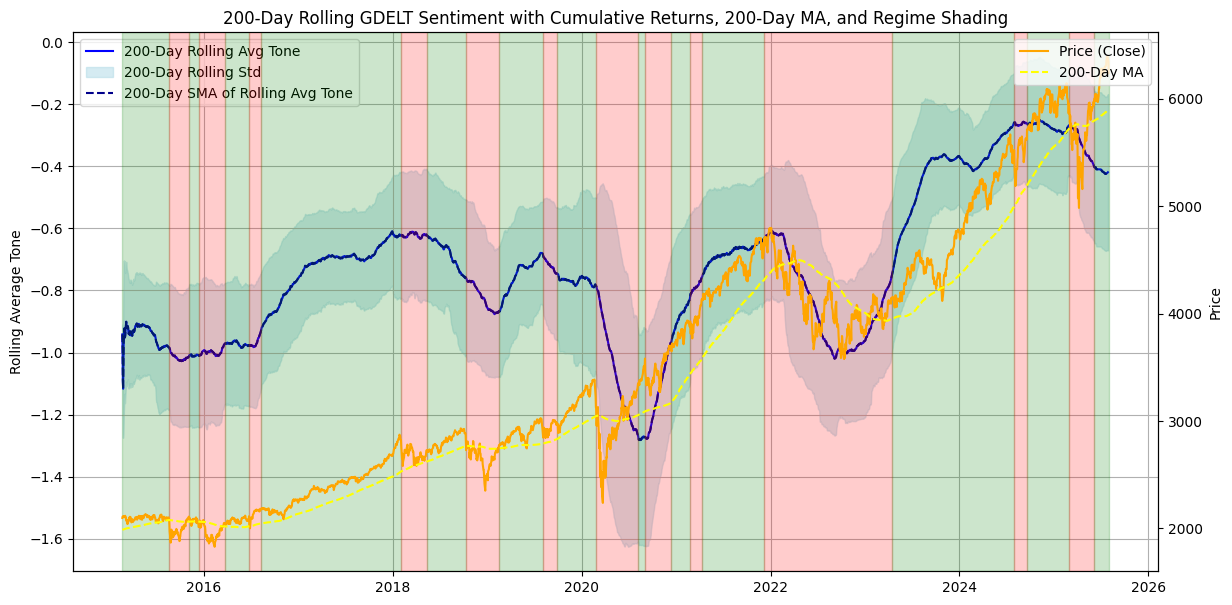

In [581]:
from datetime import datetime, timedelta

# Calculate 200 days before gkg_start
gkg_start_dt = datetime.strptime(gkg_start, "%Y-%m-%d")
gkg_start_minus_200 = (gkg_start_dt - timedelta(days=200)).strftime("%Y-%m-%d")

plot_gkg_sentiment_with_cumulative_returns(df_gkg, df, start=gkg_start, end=gkg_end, n=1)
plot_gkg_sentiment_with_cumulative_returns(df_gkg, df, start=gkg_start, end=gkg_end, n=7)
plot_gkg_sentiment_with_cumulative_returns(df_gkg, df, start=gkg_start, end=gkg_end, n=30)
plot_gkg_sentiment_with_cumulative_returns(df_gkg, df, start=gkg_start, end=gkg_end, n=90)
plot_gkg_sentiment_with_cumulative_returns(df_gkg, df, start=gkg_start, end=gkg_end, n=200)

From the graphs above, it can be seen that GDELT sentiment tends to follow regimes and price shifts (or perhaps the other way around), which is to be expected. Surprisingly, I believe that the daily GDELT sentiment graph offers the most insights. Before each large price fall, it seems that there tends to be a spike in sentiment across a small period. Anyhow, with the data at hand, let us try to create an algorithm that will let us profit moreso than a naive baseline.

The above is a rough idea of the algorithm. From the visualisation, we can see that there's a few conditions that we want to focus on, so let's define some clear conditions and guardrails for the algorithm:
- Consider **buy** only when price < 200DMA
- Consider **sell** only when price > 200DMA
- Calculate percentage confidence scores for buying or selling
- For **buy** confidence, consider if price trough is an inflexion point, 200MDA price deviation, sentiment change
- For **sell** confidence, consider if price peak is an inflexion point, 200MDA price deviation, sentiment change
- Consider modelling price direction prediction to help calculate confidence scores

In [582]:
import numpy as np
import pandas as pd

def causal_bopcd(series, window=21, threshold=2.0):
  """
  Causal Bayesian Online Point Change Detection (BOPCD) for peak/trough detection.
  Uses rolling z-score to detect significant changes (peaks/troughs) using only past data.

  Parameters:
  - series: pd.Series, time series data (e.g., smoothed price)
  - window: int, rolling window size for mean/std estimation
  - threshold: float, z-score threshold for change detection

  Returns:
  - peaks: pd.Series, detected peaks
  - troughs: pd.Series, detected troughs
  """
  rolling_mean = series.rolling(window=window, min_periods=1).mean()
  rolling_std = series.rolling(window=window, min_periods=1).std(ddof=0)
  zscore = (series - rolling_mean) / (rolling_std + 1e-8)

  peaks = series[(zscore > threshold)]
  troughs = series[(zscore < -threshold)]

  return peaks, troughs

# Example usage:
# peaks_bopcd, troughs_bopcd = causal_bopcd(smoothed, window=21, threshold=2.0)

In [583]:
print(df.head())
print(df_gkg.head())

                Close       High        Low       Open   Volume  Daily Return  \
Date                                                                            
1950-02-15  17.059999  17.059999  17.059999  17.059999  1730000      0.000000   
1950-02-16  16.990000  16.990000  16.990000  16.990000  1920000     -0.004103   
1950-02-17  17.150000  17.150000  17.150000  17.150000  1940000      0.009417   
1950-02-20  17.200001  17.200001  17.200001  17.200001  1420000      0.002916   
1950-02-21  17.170000  17.170000  17.170000  17.170000  1260000     -0.001744   

            Log Return  Cumulative Returns  Volatility  
Date                                                    
1950-02-15    0.000000            0.024010    0.006464  
1950-02-16   -0.004112            0.019808    0.006205  
1950-02-17    0.009373            0.029412    0.006376  
1950-02-20    0.002911            0.032413    0.006375  
1950-02-21   -0.001746            0.030612    0.006302  
            avg_tone  std_tone  a

In [584]:
# Use the raw closing prices as the smoothed price series for peak/trough detection
price_raw_values = df['Close']
peaks_bopcd, troughs_bopcd = causal_bopcd(price_raw_values, window=21, threshold=2.0)

In [585]:
import matplotlib.pyplot as plt

# Plot peaks, troughs, and 200DMA
def plot_turning_points(df, raw_values, peaks, troughs, start=None, end=None):
    """
    Plots the raw price series with detected peaks and troughs,
    and overlays the 200-day moving average.

    Parameters:
    - df: DataFrame with DateTime index and a '200DMA' column
    - raw_values: pd.Series, raw price series
    - peaks: pd.Series, detected peaks
    - troughs: pd.Series, detected troughs
    - start: str or datetime (optional), start date for slicing
    - end: str or datetime (optional), end date for slicing
    """
    df = df.copy()
    df.index = pd.to_datetime(df.index)
    df['200DMA'] = df['Close'].rolling(window=200, min_periods=50).mean()

    if start or end:
        df = df.loc[start:end]
        raw_values = raw_values.loc[start:end]
        peaks = peaks.loc[start:end]
        troughs = troughs.loc[start:end]

    fig, ax1 = plt.subplots(figsize=(28, 7))

    # Raw price
    ax1.plot(df.index, raw_values, label='Raw Price', color='blue')
    ax1.scatter(peaks.index, peaks.values, color='red', label='Peaks', marker='^')
    ax1.scatter(troughs.index, troughs.values, color='green', label='Troughs', marker='v')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price')
    ax1.grid(True)

    # 200-day moving average (overlayed on same axis)
    if '200DMA' in df.columns:
        ax1.plot(df.index, df['200DMA'], label='200-Day MA', color='black', linestyle='--')

    # Final formatting
    ax1.set_title('Detected Peaks and Troughs in Raw Price Series')
    ax1.legend()
    plt.show()


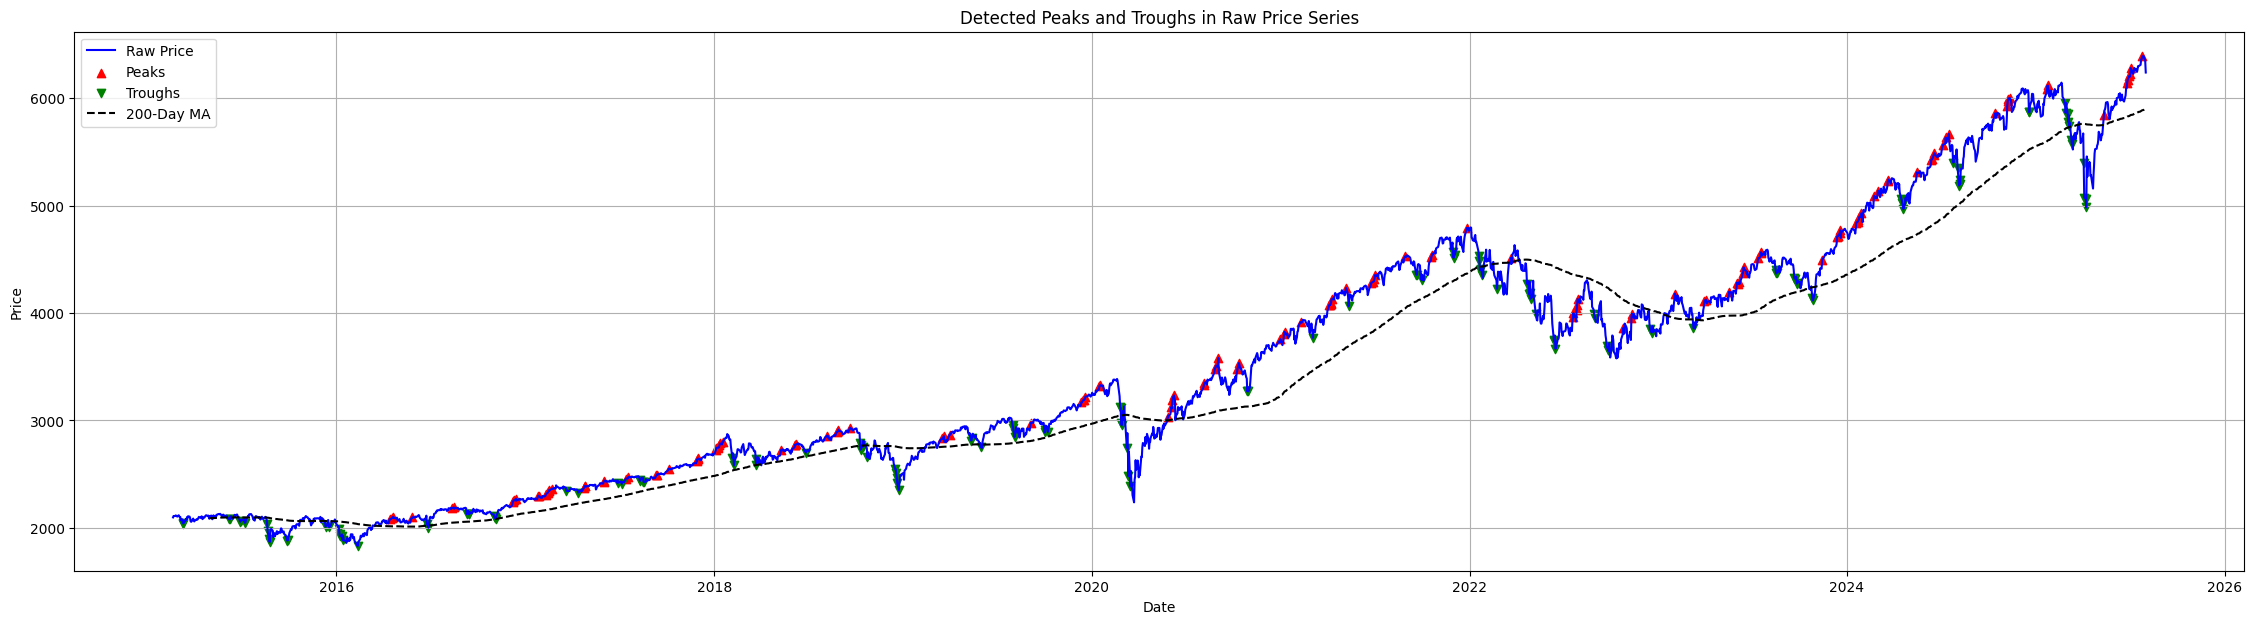

In [586]:
# Slice smoothed, peaks, and troughs to match the filtered df
df_filtered = df.loc[gkg_start:gkg_end]
raw_filtered = price_raw_values.loc[gkg_start:gkg_end]
peaks_filtered = peaks_bopcd.loc[gkg_start:gkg_end]
troughs_filtered = troughs_bopcd.loc[gkg_start:gkg_end]

plot_turning_points(df_filtered, price_raw_values, peaks_filtered, troughs_filtered, start=gkg_start, end=gkg_end)

In [592]:
def s_transform(x, k=5):
    return 2 / (1 + np.exp(-k * x)) - 1

def calculate_sentiment_confidence(row):
    if pd.isna(row['Sentiment']) or pd.isna(row['Sentiment_200DSMA']):
        return pd.Series({'Buy Confidence': np.nan, 'Sell Confidence': np.nan})
    deviation = row['Sentiment'] - row['Sentiment_200DSMA']
    buy_conf = s_transform(-deviation, k=4)
    sell_conf = s_transform(deviation, k=4)
    return pd.Series({'Buy Confidence': buy_conf, 'Sell Confidence': sell_conf})

def plot_turning_points_with_sentiment(df, df_gkg, peaks, troughs, start=None, end=None):
    # --- Prepare price data ---
    df = df.copy()
    df.index = pd.to_datetime(df.index)

    # Ensure df_gkg index is datetime
    df_gkg = df_gkg.copy()
    if not isinstance(df_gkg.index, pd.DatetimeIndex):
        df_gkg.index = pd.to_datetime(df_gkg.index)

    # Merge and compute features
    df = df.merge(df_gkg, left_index=True, right_index=True, how='left')
    df['Sentiment'] = df['avg_tone'].rolling(window=90, min_periods=30).mean()
    df['Sentiment_200DSMA'] = df['Sentiment'].rolling(window=200, min_periods=50).mean()
    df['200DMA'] = df['Close'].rolling(window=200, min_periods=50).mean()

    # Apply sentiment-based confidence
    sentiment_confidence = df.apply(calculate_sentiment_confidence, axis=1)
    df = pd.concat([df, sentiment_confidence], axis=1)

    # Date filter at the end
    if start or end:
        df = df.loc[start:end]
        peaks = peaks.loc[start:end]
        troughs = troughs.loc[start:end]

    # Align confidence to peaks/troughs
    peaks_conf = df['Sell Confidence'].reindex(peaks.index).fillna(0)
    troughs_conf = df['Buy Confidence'].reindex(troughs.index).fillna(0)

    # --- Plotting ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(28, 10), sharex=True, height_ratios=[2, 1])

    # Price and turning points (ax1)
    ax1.plot(df.index, df['Close'], label='Raw Price', color='blue')
    ax1.plot(df.index, df['200DMA'], label='200DMA', color='black', linestyle='--')

    ax1.scatter(peaks.index, peaks.values,
                s=np.square(peaks_conf) * 500 + 10,
                color='red', label='Peaks', marker='^', edgecolors='black', zorder=5)

    ax1.scatter(troughs.index, troughs.values,
                s=np.square(troughs_conf) * 500 + 10,
                color='green', label='Troughs', marker='v', edgecolors='black', zorder=5)

    ax1.set_title('Turning Points with Sentiment-Based Confidence')
    ax1.set_ylabel('Price')
    ax1.legend()
    ax1.grid(True)

    # Confidence subplot (ax2)
    ax2.plot(df.index, df['Buy Confidence'], color='green', label='Buy Confidence')
    ax2.plot(df.index, df['Sell Confidence'], color='red', label='Sell Confidence')
    ax2.axhline(0, color='gray', linestyle='--')
    ax2.set_ylabel('Confidence')
    ax2.set_xlabel('Date')
    ax2.set_ylim(0, 1)
    ax2.legend()
    ax2.grid(True)
    ax2.set_title('Sentiment-Based Confidence Scores Over Time')

    plt.tight_layout()
    plt.show()

    return df


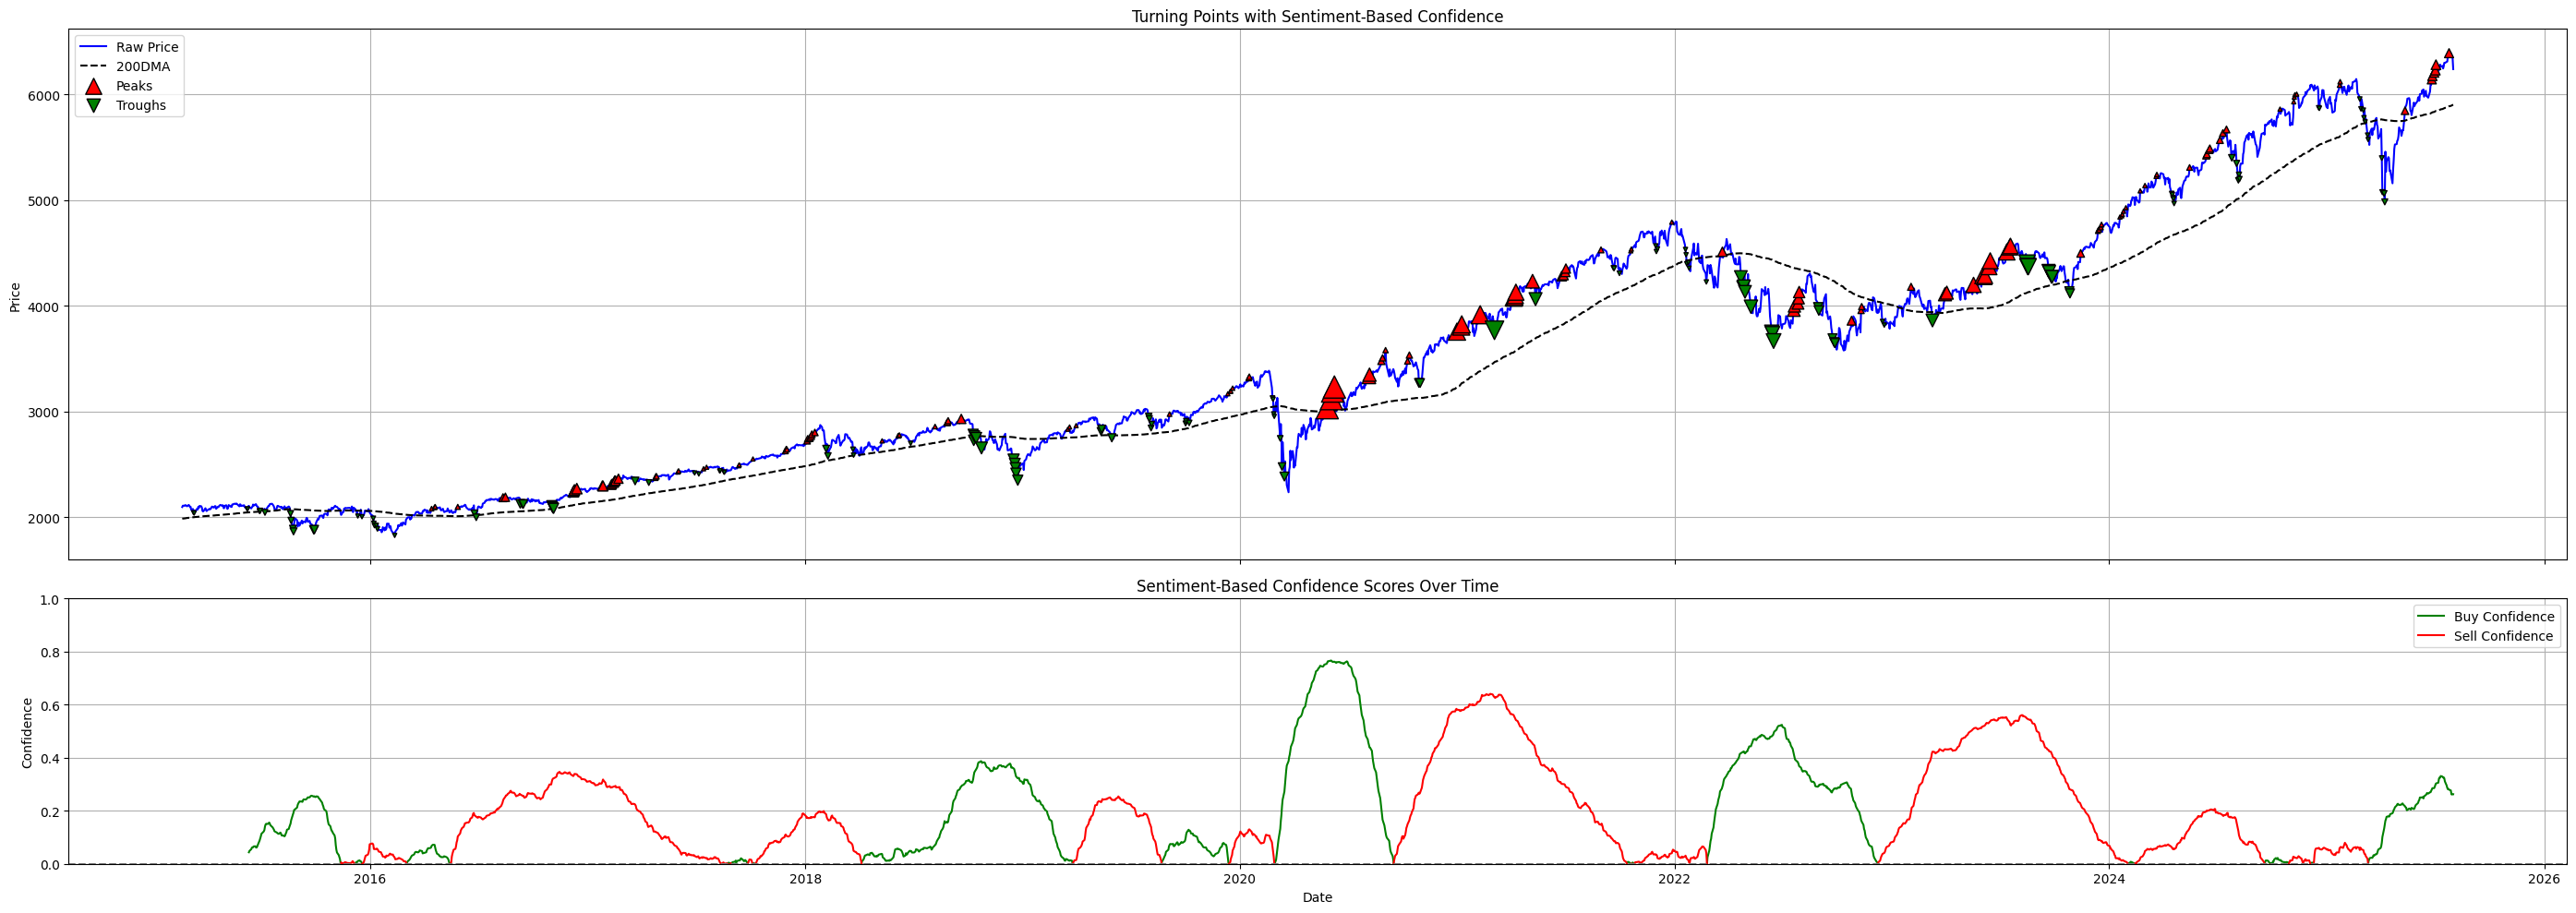

In [593]:
df_with_sentiment = plot_turning_points_with_sentiment(df, df_gkg, peaks_filtered, troughs_filtered, start=gkg_start, end=gkg_end)